In [1]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation


import importlib
importlib.reload(meld_graph)
importlib.reload(meld_graph.models)
importlib.reload(meld_graph.dataset)
importlib.reload(meld_graph.experiment)
importlib.reload(meld_graph.data_preprocessing)
importlib.reload(meld_graph.evaluation)

import logging
import os
import json
import h5py

from meld_graph.dataset import GraphDataset, Oversampler
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_graph.training import Metrics
import numpy as np
from meld_graph.paths import EXPERIMENT_PATH

from meld_graph.evaluation import Evaluator



Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1


# Compare models already evaluated

### Initialise models and folds

In [2]:
# initialise results you want to compare

model_base_paths = {
   # 'dcd': '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/22-12-13_evaluation_real_valsdata_test_folds/dcd',
   'dcd_mae_weighted': '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/22-12-13_evaluation_real_valsdata_test_folds/dcd_mae_weighted',
   # 'dice_ce': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-12-14_evaluation_real_valsdata/dice_ce',
}

folds = np.arange(0,3)

### Plot results curves as function of threshold

0.0
0.0


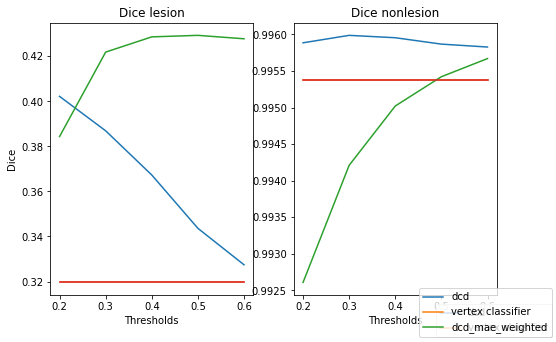

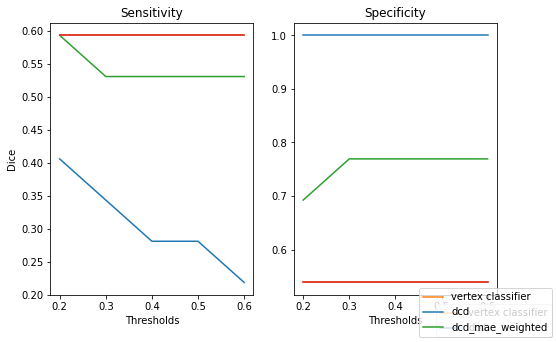

In [51]:
# plot curves dices score at different threshold

import h5py
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

from meld_graph.training import tp_fp_fn_tn, get_sensitivity, dice_coeff
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import torch


features=['']
threshes = [0.2,0.3,0.4,0.5,0.6]

c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')
              
# get list of sujects from 1st model and 1 fold
with h5py.File(os.path.join(f'{model_base_paths[list(set(model_base_paths))[0]]}_fold0', 'results', 'predictions.hdf5'), "r") as f:
    subjects =  np.array(list(f.keys()))

predictions_file_1 = os.path.join('/rds/project/kw350',
             'rds-kw350-meld/experiments',
             'co-ripa1/iteration_21-09-15/ensemble_21-09-15',
             'fold_all/results/',
             'predictions_ensemble_iteration.hdf5')

predictions_file_2 = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')

# fig, ax =plt.subplots(len(model_base_paths.keys()), 2, figsize=(20,30))
fig, ax =plt.subplots(1,2,figsize=(8,5))
fig2, ax2 = plt.subplots(1,2, figsize=(8,5))

for i, model_name in enumerate(model_base_paths.keys()):  
    
    predictions_file = os.path.join(model_base_paths[model_name]+'_fold{}', 'results', 'predictions.hdf5')
    
    #### compute for multiple threshold with function from training
    stored_scores=[[],[],[],[],[],[]]

    for si,subject in enumerate(subjects):
        # print(subject)
        if si%100==0:
            print(si/len(subjects))
            
        results=[]
        try:
            hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                        'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                        'results','predictions_ensemble_iteration.hdf5')
            result_hemis = load_prediction(subject,hdf_predictions)
            results.append(result_hemis)
        except KeyError:
            hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                        'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                        'results','predictions_ensemble_iteration.hdf5')
            result_hemis = load_prediction(subject,hdf_predictions)
            results.append(result_hemis)
        
        #loop over folds and average predictions
        new_result_hemis_folds_lh = []
        new_result_hemis_folds_rh = []
        for f,fold in enumerate(folds):
            new_result_hemis_folds_lh.append(load_prediction(subject,predictions_file.format(fold))['lh'])
            new_result_hemis_folds_rh.append(load_prediction(subject,predictions_file.format(fold))['rh'])
        new_result_hemis = {'lh': np.array(new_result_hemis_folds_lh).mean(0),
                            'rh': np.array(new_result_hemis_folds_rh).mean(0)}
        
        #threshold predictions
        for t in threshes:
            ti={}
            for hemi in ['lh','rh']:
                ti[hemi]=new_result_hemis[hemi]>t
            
            results.append(ti)           
        
        subj = MeldSubject(subject,cohort=c)
        detected = False
        stats_stored = np.zeros((len(results),4))
        dices = np.zeros((len(results),2))

        pred={}
        target={}
        
        for hemi in ['lh','rh']:
            _, label = subj.load_feature_lesion_data(
                features, hemi=hemi, features_to_ignore=[])
            
            pred[hemi] = results[hemi].astype('bool')
            target[hemi] = label[c.cortex_mask]
            
            preds = torch.as_tensor(np.array(np.hstack([pred['lh'], pred['rh']]))).long()
            targets = torch.as_tensor(np.array(np.hstack([target['lh'], target['rh']]))).long()
            stats_stored=tp_fp_fn_tn(preds, targets)
            dices = dice_coeff(torch.nn.functional.one_hot(preds, num_classes=2),targets)
        

    # compute mean dices for cohort
    patient_only = (np.array(stored_scores)[0,:,1]=='True')
    stored_dices_array = (np.array(stored_scores)[:,:,7]).astype('float').mean(axis=1)
    stored_nondices_array = (np.array(stored_scores)[:,:,6]).astype('float').mean(axis=1)

    # compute sensitivity and specificity
    stored_sensitivity_array = (np.array(stored_scores)[:,patient_only,2].astype('float')>0).sum(axis=1)/patient_only.sum()
    stored_specificity_array = (np.array(stored_scores)[:,~patient_only,3].astype('float')==0.0).sum(axis=1)/(~patient_only).sum()

    
    ax[0].plot(threshes,stored_dices_array[1:], label=model_name)
    if i==0:
        ax[0].plot([threshes[0],threshes[-1]],[stored_dices_array[0],stored_dices_array[0]],label='vertex classifier')
    else:
        ax[0].plot([threshes[0],threshes[-1]],[stored_dices_array[0],stored_dices_array[0]])
    ax[0].set_xlabel('Thresholds')
    ax[0].set_ylabel('Dice')
    ax[0].set_title("Dice lesion")
    #,stored_nondice
    ax[1].plot(threshes,stored_nondices_array[1:])
    ax[1].plot([threshes[0],threshes[-1]],[stored_nondices_array[0],stored_nondices_array[0]])
    #,stored_nondice
    ax[1].set_xlabel('Thresholds')
    ax[1].set_title("Dice nonlesion")
    fig.legend(loc='lower right')

    ax2[0].plot(threshes,stored_sensitivity_array[1:],)
    if i==0:
        ax2[0].plot([threshes[0],threshes[-1]],[stored_sensitivity_array[0],stored_sensitivity_array[0]],label='vertex classifier')
    else:
        ax2[0].plot([threshes[0],threshes[-1]],[stored_sensitivity_array[0],stored_sensitivity_array[0]])
    ax2[0].set_xlabel('Thresholds')
    ax2[0].set_ylabel('Dice')

    ax2[0].set_title("Sensitivity")
    #,stored_nondice
    ax2[1].plot(threshes,stored_specificity_array[1:], label=model_name)
    ax2[1].plot([threshes[0],threshes[-1]],[stored_specificity_array[0],stored_specificity_array[0]])
    #,stored_nondice
    ax2[1].set_xlabel('Thresholds')
    ax2[1].set_title("Specificity")
    fig2.legend(loc='lower right')

### Plot results at a certain threshold

In [8]:
#### compute for multiple threshold with function from training
import h5py
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

from meld_graph.training import tp_fp_fn_tn, get_sensitivity, dice_coeff
import pandas as pd
import scipy.stats as st
import torch

features=['']
threshold=0.2
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')
              
# get list of sujects from 1st model and 1 fold
with h5py.File(os.path.join(f'{model_base_paths[list(set(model_base_paths))[0]]}_fold0', 'results', 'predictions.hdf5'), "r") as f:
    subjects =  np.array(list(f.keys()))


for i, model_name in enumerate(model_base_paths.keys()):  
    df = pd.DataFrame()
    values={}
    
    predictions_file = os.path.join(model_base_paths[model_name]+'_fold{}', 'results', 'predictions.hdf5')

    for si,subject in enumerate(subjects):
        if si%100==0:
            print(si/len(subjects))
            
        results=[]

        subj = MeldSubject(subject,cohort=c)
        detected = False
        stats_stored = np.zeros((len(results),4))
        dices = np.zeros((len(results),2))
        values['ID']=subject
        values['group']=subj.group
        pred={}
        target={}

        #loop over folds and average predictions
        new_result_hemis_folds_lh = []
        new_result_hemis_folds_rh = []
        for f,fold in enumerate(folds):
            new_result_hemis_folds_lh.append(load_prediction(subject,predictions_file.format(fold))['lh'])
            new_result_hemis_folds_rh.append(load_prediction(subject,predictions_file.format(fold))['rh'])
        new_result_hemis = {'lh': np.array(new_result_hemis_folds_lh).mean(0),
                    'rh': np.array(new_result_hemis_folds_rh).mean(0)}
        
        #threshold predictions
        results={}
        for hemi in ['lh','rh']:
            results[hemi]=new_result_hemis[hemi]>threshold

        for hemi in ['lh','rh']:
            _, label = subj.load_feature_lesion_data(
                features, hemi=hemi, features_to_ignore=[])
            
            pred[hemi] = results[hemi].astype('bool')
            target[hemi] = label[c.cortex_mask]
        
        preds = torch.as_tensor(np.array(np.hstack([pred['lh'], pred['rh']]))).long()
        targets = torch.as_tensor(np.array(np.hstack([target['lh'], target['rh']]))).long()
        stats_stored=tp_fp_fn_tn(preds, targets)
        dices = dice_coeff(torch.nn.functional.one_hot(preds, num_classes=2),targets)
        values['tp'] = np.array(stats_stored)[0].astype('float')
        values['fp'] = np.array(stats_stored)[1].astype('float')
        values['size pred'] = np.array((preds>0).sum()).astype('float')
        values['dice lesional'] = np.array(dices)[1].astype('float')
        values['dice non-lesional'] = np.array(dices)[0].astype('float')
        df=pd.concat([df, pd.DataFrame([values])])

    # print results
    mean_dice_les = df[df['group']=='patient']['dice lesional'].mean()
    print(f'mean dice lesional patient : {mean_dice_les}')

    mean_dice_les_all = df['dice lesional'].mean()
    print(f'mean dice lesional all : {mean_dice_les_all}')

    mean_dice_nonles_all = df['dice non-lesional'].mean()
    print(f'mean dice non lesional all : {mean_dice_nonles_all}')

    sensitivity = len(df[(df['group']=='patient') & (df['tp']>0)])/len(df[(df['group']=='patient')])
    print(f'sensitivity patient : {sensitivity}')

    specificity = len(df[(df['group']=='control') & (df['fp']==0)])/len(df[(df['group']=='control')])
    print(f'specificity controls : {specificity}')

0.0
mean dice lesional patient : 0.25925833036308177
mean dice lesional all : 0.3843614793693026
mean dice non lesional all : 0.9926083948877122
sensitivity patient : 0.59375
specificity controls : 0.6923076923076923
